In [1]:
from ultralytics import YOLO
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import skimage
from PIL import Image
from detection_utils import *
from keypoint_utils import *

import importlib
from sklearn.metrics import mean_squared_error
import json
import yaml
import time
import supervision as sv
from inference import get_model
print(sv.__version__)


[01/14/25 13:56:04] WARNING  Your inference package version 0.30.0 is out of date! Please upgrade to ]8;id=758420;file:///home/gp106653/miniconda3/envs/soccer/lib/python3.8/site-packages/inference/core/__init__.py\__init__.py]8;;\:]8;id=465017;file:///home/gp106653/miniconda3/envs/soccer/lib/python3.8/site-packages/inference/core/__init__.py#41\41]8;;\
                             version 0.33.0 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

0.22.0


In [111]:
src="./videos/dbf_18.mp4"


In [77]:
model = get_model(
    model_id="football-ball-detection-rejhg/4", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


In [78]:
model_keypoints = get_model(
    model_id="football-field-detection-f07vi/14", 
    api_key="fpgo7lotAA2MTZARBCtt"
)


Normal prediction [[        798         545         812         558     0.71483]]
Patches prediction []


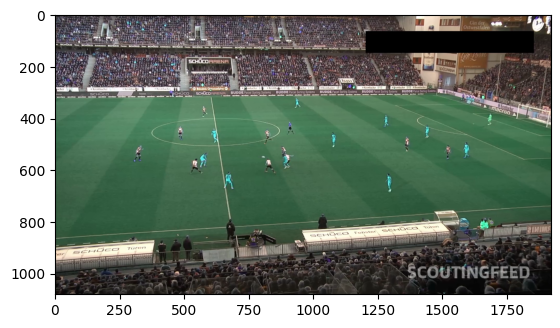

In [112]:
# Check prediction for indv frames

import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
# Specify the path to the video file
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
else:
# Read the first frame
    pass
frame_number=1
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
success, frame = cap.read()

slice_dimensions = (640, 480)  # Width and height for slicing
overlap_dimensions = (100, 100)  # Overlap between slices
slice_wh=slice_dimensions
overlap_wh=overlap_dimensions
if success:
    
    
    #frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    detection_frame=normal_prediction(model, frame, frame_number,0.3,0.4)
    print("Normal prediction",detection_frame)
    #Run ball detection inference on patches
    patches = slice_frame(frame, slice_wh, overlap_wh)
    detection_frame,det_ball = infer_on_patches(model, patches, frame_number,0.6,0.4)
    print("Patches prediction",detection_frame)

In [113]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
# Specify the path to the video file
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Unable to open video file.")
else:
# Read the first frame
    pass

# Get video properties for output writer
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))




slice_dimensions = (640, 480)  # Width and height for slicing
overlap_dimensions = (100, 100)  # Overlap between slices
slice_wh=slice_dimensions
overlap_wh=overlap_dimensions

frame_number=0
# Initialize the BallTracker
tracker = centroid_track.BallTracker(buffer_size=5)


# Intialize DeepSort

ball_positions = []
yolo_detections=[]
first=False
all_frames=[]
frame_number=0
# Read all the frames
all_keypoints=[]
det_conf=0.4
keyp_conf=0.8
while True:
    ret, frame = cap.read()
    if not ret:
        break
    all_frames.append(frame)
    #Run ball detection inference on patches
    #patches = slice_frame(frame, slice_wh, overlap_wh)
    #detection_frame,det_ball = infer_on_patches(model, patches, frame_number,0.6,0.4)

    #Run ball detection inference on a single FRAME
    detection_frame=normal_prediction(model, frame, frame_number,0.3,0.4)

    #print(" detection frame length is:  ",len(detection_frame))
    if len(detection_frame)>1:
        print("================Multiple BALL DETECTION==================")

    ## Run keypoint detection inference on single Frame

    kpoints = keypoint_utils.keypoint_prediction(model_keypoints,frame,det_conf,keyp_conf)
    if kpoints:
        all_keypoints.append(kpoints)
    else:
        print("Appending None KEYPOINTS")
        all_keypoints.append([{}])


    det=False
    detections_track = []

    if isinstance(detection_frame, np.ndarray) and detection_frame.size > 0:  # Check if it's a NumPy array with elements
        #print("inside the FIRST instance-----111")
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            detections_track.append([x_centroid,y_centroid ])  # Append the centroid
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)

        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
        print("Detection is True")
    elif isinstance(detection_frame, list) and len(detection_frame) > 0:  # Check if it's a non-empty list
        for dets in detection_frame:
            x1, y1, x2, y2, conf = dets
            x_centroid=(x1 + x2) // 2
            y_centroid=(y1 + y2) // 2
            
            detections_track.append([x_centroid,y_centroid ]) 
        detections_track = np.array(detections_track)
        tracked_ball = tracker.update(detections_track)
        ball_positions.append((tracked_ball[0], tracked_ball[1]))  # Store centroid
        det=True
        print("Detection is True")
    else:
        #print("Inside none tracker-------")
        tracked_ball = tracker.update(None)  
        ball_positions.append((np.nan,np.nan))
        det=False
        print("Detection is False")
    print("The ball position is: ",ball_positions)
    print("The frame number is :",frame_number)
    frame_number+=1
    if frame_number==20:
        pass
        #break
# Release the video capture object
cap.release()



        




Detection is False
The ball position is:  [(nan, nan)]
The frame number is : 0
the distances are:  [          0]
the index are:  0
Detection is True
The ball position is:  [(nan, nan), (805.0, 551.0)]
The frame number is : 1
Detection is False
The ball position is:  [(nan, nan), (805.0, 551.0), (nan, nan)]
The frame number is : 2
Detection is False
The ball position is:  [(nan, nan), (805.0, 551.0), (nan, nan), (nan, nan)]
The frame number is : 3
the distances are:  [     48.662]
the index are:  0
Detection is True
The ball position is:  [(nan, nan), (805.0, 551.0), (nan, nan), (nan, nan), (757.0, 543.0)]
The frame number is : 4
Detection is False
The ball position is:  [(nan, nan), (805.0, 551.0), (nan, nan), (nan, nan), (757.0, 543.0), (nan, nan)]
The frame number is : 5
Detection is False
The ball position is:  [(nan, nan), (805.0, 551.0), (nan, nan), (nan, nan), (757.0, 543.0), (nan, nan), (nan, nan)]
The frame number is : 6
Detection is False
The ball position is:  [(nan, nan), (8

In [114]:
print(len(ball_positions))
print(len(all_frames))
print(len(all_keypoints))

750
750
750


In [115]:
# Save the ball posotion and keypoints array
ballpos_array=np.array(ball_positions)
np.save("ballposition_array_18.npy", ballpos_array)
all_keypoints_array=np.array(all_keypoints)
np.save("keypoints_array_18.npy", all_keypoints_array)

In [116]:
# load the ball position and keypoints array
all_keypoints = list(np.load("keypoints_array_18.npy",allow_pickle=True))

ball_positions = list(np.load("ballposition_array_18.npy",allow_pickle=True))

In [117]:
all_keypoints

[[{'keypoints': (631.0, 328.0), 'class': '15', 'conf': 0.9987574815750122},
  {'keypoints': (623.0, 405.0), 'class': '16', 'conf': 0.999598503112793},
  {'keypoints': (615.0, 504.0), 'class': '17', 'conf': 0.9996191263198853},
  {'keypoints': (597.0, 829.0), 'class': '18', 'conf': 0.9863139390945435},
  {'keypoints': (1314.0, 351.0), 'class': '20', 'conf': 0.9981763362884521},
  {'keypoints': (1414.0, 392.0), 'class': '21', 'conf': 0.9966529607772827},
  {'keypoints': (1576.0, 466.0), 'class': '22', 'conf': 0.9638113975524902},
  {'keypoints': (1608.0, 421.0), 'class': '24', 'conf': 0.9286981821060181},
  {'keypoints': (1618.0, 383.0), 'class': '25', 'conf': 0.918354332447052},
  {'keypoints': (1488.0, 317.0), 'class': '27', 'conf': 0.9833722114562988},
  {'keypoints': (1595.0, 346.0), 'class': '28', 'conf': 0.9242064952850342},
  {'keypoints': (372.0, 459.0), 'class': '14', 'conf': 0.9845007658004761},
  {'keypoints': (860.0, 445.0), 'class': '19', 'conf': 0.9998844265937805}],
 [{'ke

In [118]:
yolo=False
df_positions = pd.DataFrame(ball_positions, columns=["x", "y"])
df_positions = df_positions.interpolate(method='linear').bfill()  # Interpolate missing values
position_array=list(df_positions.values)

# Define the codec and create VideoWriter object
output_path = './videos/dbf_18_out.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'MP4V' for MP4 files
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

for current_positions,frame in zip(position_array,all_frames):
 
    

    # Get the current interpolated position for this frame
    x, y = current_positions
    
    if not np.isnan(x) and not np.isnan(y):
        
        x, y = int(x), int(y)
        # Draw interpolated circle
        cv2.circle(frame, (x, y), radius=10, color=(255, 0, 255), thickness=2)

    #Draw raw detections from YOLO
    if yolo:

        x1=int(x1)
        x2=int(x2)
        y1=int(y1)
        y2=int(y2)
        color = (0, 255, 0)
        thickness = 2
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness)
        x,y,w,h=xyxy2xywh(x1,y1,x2,y2)






    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    out.write(frame)
    

In [119]:
from soccer_config import SoccerPitchConfiguration
import keypoint_homography
from keypoint_homography import Transform
CONFIG = SoccerPitchConfiguration()

In [120]:
index_frame_number=5

True

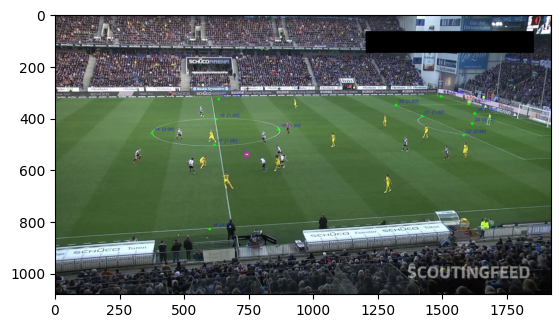

In [121]:
import centroid_track
import detection_utils
import keypoint_utils
importlib.reload(centroid_track)
importlib.reload(detection_utils)
importlib.reload(keypoint_utils)
keypoint_frames=keypoint_utils.draw_keypoints(all_keypoints,all_frames)
plt.figure()

plt.imshow(keypoint_frames[index_frame_number])
fr=keypoint_frames[index_frame_number]
frame_rgb=cv2.cvtColor(fr, cv2.COLOR_BGR2RGB) 
cv2.imwrite("keypoints_field.png",frame_rgb )

In [122]:
vert=CONFIG.vertices
print(vert)

[(0, 0), (0, 1450.0), (0, 2584.0), (0, 4416.0), (0, 5550.0), (0, 7000), (550, 2584.0), (550, 4416.0), (1100, 3500.0), (2015, 1450.0), (2015, 2584.0), (2015, 4416.0), (2015, 5550.0), (6000.0, 0), (6000.0, 2585.0), (6000.0, 4415.0), (6000.0, 7000), (9985, 1450.0), (9985, 2584.0), (9985, 4416.0), (9985, 5550.0), (10900, 3500.0), (11450, 2584.0), (11450, 4416.0), (12000, 0), (12000, 1450.0), (12000, 2584.0), (12000, 4416.0), (12000, 5550.0), (12000, 7000), (5085.0, 3500.0), (6915.0, 3500.0)]


In [123]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import soccer_config
importlib.reload(soccer_config)
from soccer_config import SoccerPitchConfiguration
# Define the image size (in pixels)
img_width = 1200
img_height = 700

# Initialize soccer pitch configuration
pitch = SoccerPitchConfiguration()

# Create a blank image (white background)
img = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255

# Define scaling factors based on physical dimensions
x_scale = img_width / pitch.length
y_scale = img_height / pitch.width

# Function to scale coordinates
def scale_coordinates(x, y):
    return int(x * x_scale), int(y * y_scale)

# List to store the scaled coordinates
scaled_coord = []

# Plot the vertices and edges
for idx, (x, y) in enumerate(pitch.vertices):
    x_scaled, y_scaled = scale_coordinates(x, y)
    print("The idx is: and its x y scaled is: ",idx,x,y)
    # Draw the vertex as a small circle
    cv2.circle(img, (x_scaled, y_scaled), 8, (0, 0, 0), -1)  # Black dot for the vertex
    # Annotate the point with label (if you need this step)
    cv2.putText(img, pitch.labels[idx], (x_scaled + 10, y_scaled + 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Save the scaled coordinates
    scaled_coord.append((x_scaled, y_scaled))

# Plot the edges (lines connecting the vertices)
for edge in pitch.edges:
    # Get the start and end vertices of the edge
    x1, y1 = pitch.vertices[edge[0] - 1]
    x2, y2 = pitch.vertices[edge[1] - 1]
    
    # Scale the coordinates to image space
    x1_scaled, y1_scaled = scale_coordinates(x1, y1)
    x2_scaled, y2_scaled = scale_coordinates(x2, y2)
    
    # Draw the line between the two points (green color)
    cv2.line(img, (x1_scaled, y1_scaled), (x2_scaled, y2_scaled), (0, 255, 0), 2)  # Green color for edges

# Plot the center circle
center_x, center_y = pitch.length / 2, pitch.width / 2  # The center of the field
center_scaled_x, center_scaled_y = scale_coordinates(center_x, center_y)  # Scale to image coordinates
centre_circle_radius_scaled = pitch.centre_circle_radius * x_scale  # Scale the radius to match the image

# Draw the center circle
cv2.circle(img, (center_scaled_x, center_scaled_y), int(centre_circle_radius_scaled), (0, 255, 0), 2)  # Green circle

# Save the figure as an image file
cv2.imwrite("soccer_pitch_with_circle_scaled_cv2.png", img)


The idx is: and its x y scaled is:  0 0 0
The idx is: and its x y scaled is:  1 0 1450.0
The idx is: and its x y scaled is:  2 0 2584.0
The idx is: and its x y scaled is:  3 0 4416.0
The idx is: and its x y scaled is:  4 0 5550.0
The idx is: and its x y scaled is:  5 0 7000
The idx is: and its x y scaled is:  6 550 2584.0
The idx is: and its x y scaled is:  7 550 4416.0
The idx is: and its x y scaled is:  8 1100 3500.0
The idx is: and its x y scaled is:  9 2015 1450.0
The idx is: and its x y scaled is:  10 2015 2584.0
The idx is: and its x y scaled is:  11 2015 4416.0
The idx is: and its x y scaled is:  12 2015 5550.0
The idx is: and its x y scaled is:  13 6000.0 0
The idx is: and its x y scaled is:  14 6000.0 2585.0
The idx is: and its x y scaled is:  15 6000.0 4415.0
The idx is: and its x y scaled is:  16 6000.0 7000
The idx is: and its x y scaled is:  17 9985 1450.0
The idx is: and its x y scaled is:  18 9985 2584.0
The idx is: and its x y scaled is:  19 9985 4416.0
The idx is: and 

True

In [124]:
scaled_coord

[(0, 0),
 (0, 145),
 (0, 258),
 (0, 441),
 (0, 555),
 (0, 700),
 (55, 258),
 (55, 441),
 (110, 350),
 (201, 145),
 (201, 258),
 (201, 441),
 (201, 555),
 (600, 0),
 (600, 258),
 (600, 441),
 (600, 700),
 (998, 145),
 (998, 258),
 (998, 441),
 (998, 555),
 (1090, 350),
 (1145, 258),
 (1145, 441),
 (1200, 0),
 (1200, 145),
 (1200, 258),
 (1200, 441),
 (1200, 555),
 (1200, 700),
 (508, 350),
 (691, 350)]

In [125]:
labels=pitch.labels

In [126]:
img=cv2.imread("soccer_pitch_with_circle_scaled_cv2.png")

In [127]:
# Create a mapping from labels to vertices
label_to_vertex = {label: vertex for label, vertex in zip(labels, scaled_coord)}
frame_size = (1200, 700)
output_file = "videos/heatmap_dbf_18.avi"  # Output video file nam
frame_rate = fps
# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec for the video
video_writer = cv2.VideoWriter(output_file, fourcc, frame_rate, frame_size)
# Filter vertices based on the keypoints' classes
for idx in range(len(all_frames)):
    filtered_vertices = []
    filtered_keypoints = []
    kpts=all_keypoints[idx]
    if not kpts == [{}] and len(kpts)>4:
        
        for kp in kpts:
                label = kp['class']
                if label in label_to_vertex:
                    filtered_vertices.append(label_to_vertex[label])
                    filtered_keypoints.append(kp['keypoints'])
        

        # Output the results
        #print("Filtered Vertices:", filtered_vertices)
        #print("Filtered Keypoints:", filtered_keypoints)

        final_vert_array=np.array(filtered_vertices)
        final_kpts_array=np.array(filtered_keypoints)
        transformer = Transform(
            source=final_kpts_array.astype(np.float32),
            target=final_vert_array.astype(np.float32)
        )
        pts_2d=position_array[idx].reshape(1, -1) 
        pts_2d
        final_img=transformer.transform_points(points=pts_2d)

        center = final_img[0] # Example center coordinates in (x, y)
        center=tuple(center.astype(int)) 

        # Define the radius of the circle
        radius = 9  # You can adjust this value as needed

        # Define the color of the circle (BGR format)
        color = (0, 0, 255)  # Red color

        # Define the thickness of the circle's border
        thickness = 5  # If you want a filled circle, use -1 for thickness

        # Draw the circle on the image
        temp_img=img.copy()
        cv2.circle(temp_img, center, radius, color, thickness)
    else:
        print("In else:")
    #plt.imshow(img)
     # Write the modified frame to the video
    video_writer.write(temp_img)
    #break
video_writer.release()

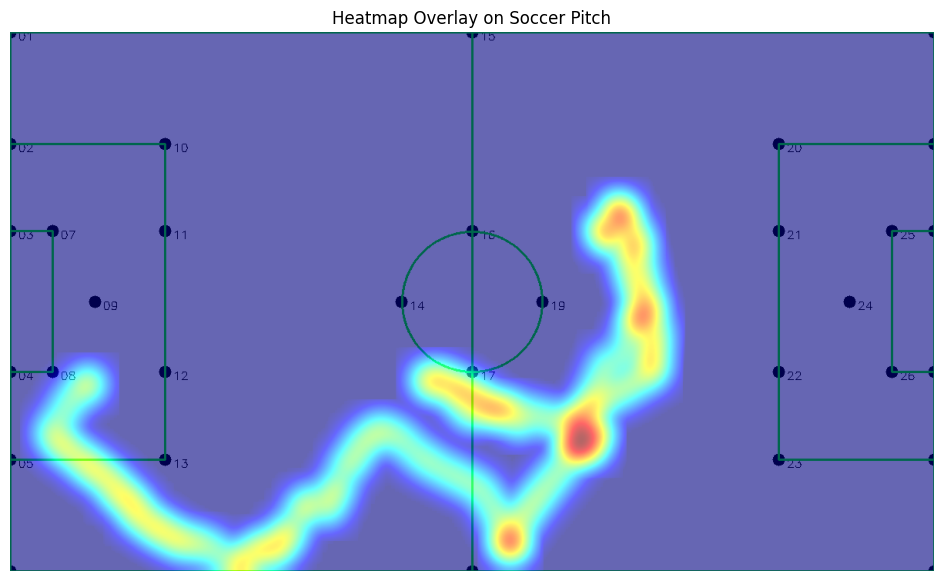

True

In [128]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the projected soccer pitch image
img = cv2.imread("soccer_pitch_with_circle_scaled_cv2.png")
frame_height, frame_width, _ = img.shape

# Initialize heatmap grid
heatmap = np.zeros((frame_height, frame_width), dtype=np.float32)

# Example ball positions - replace this with your data
# ball_positions = [(x1, y1), (x2, y2), ...] collected earlier
ball_positions = []  # Collect all ball positions for debugging

# Collect ball positions (replace with your loop to update positions)
for idx in range(len(all_frames)):
    kpts = all_keypoints[idx]
    if not kpts == [{}] and len(kpts) > 4:
        filtered_vertices = []
        filtered_keypoints = []

        for kp in kpts:
            label = kp['class']
            if label in label_to_vertex:
                filtered_vertices.append(label_to_vertex[label])
                filtered_keypoints.append(kp['keypoints'])

        final_vert_array = np.array(filtered_vertices)
        final_kpts_array = np.array(filtered_keypoints)
        transformer = Transform(
            source=final_kpts_array.astype(np.float32),
            target=final_vert_array.astype(np.float32)
        )
        pts_2d = position_array[idx].reshape(1, -1)
        final_img = transformer.transform_points(points=pts_2d)

        center = final_img[0]
        center = tuple(center.astype(int))

        # Update heatmap
        if 0 <= center[0] < frame_width and 0 <= center[1] < frame_height:
            heatmap[center[1], center[0]] += 1  # Increment the cell
            ball_positions.append(center)  # Collect positions

# Apply Gaussian blur to the heatmap
heatmap = cv2.GaussianBlur(heatmap, (81, 81), 0)

# Normalize the heatmap
heatmap = heatmap / np.max(heatmap)
heatmap = np.power(heatmap, 0.3)
# Convert heatmap to color
heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

# Blend the heatmap with the original image
alpha = 0.6  # Transparency factor
overlay = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)

# Display the result
plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.title("Heatmap Overlay on Soccer Pitch")
plt.axis('off')
plt.show()

# Optionally, save the result
cv2.imwrite("heatmap_overlay_18.png", overlay)



In [38]:
np.max(heatmap)
heatmap.shape


(700, 1200)

In [24]:

center = final_img[0] # Example center coordinates in (x, y)

# Define the radius of the circle
radius = 9  # You can adjust this value as needed

# Define the color of the circle (BGR format)
color = (0, 0, 255)  # Red color

# Define the thickness of the circle's border
thickness = 5  # If you want a filled circle, use -1 for thickness

# Draw the circle on the image
cv2.circle(img, center, radius, color, thickness)
plt.imshow(img)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [25]:
img.shape

(700, 1200, 3)

In [26]:
video_path = src

# Open the video file
cap = cv2.VideoCapture(video_path)
frame_nu=10
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_nu)

# Read the specific frame
success, frame = cap.read()
frame_rgb=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 

In [129]:
# Paths to the original video and the heatmap video
original_video_path = './videos/dbf_18_out.avi'
heatmap_video_path = './videos/heatmap_dbf_18.avi'
output_combined_path = './videos/combined_output_dbf_18.avi'

# Open both videos
original_cap = cv2.VideoCapture(original_video_path)
heatmap_cap = cv2.VideoCapture(heatmap_video_path)

# Get video properties from the original video
frame_width = int(original_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(original_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(frame_width,frame_height)
fps = int(original_cap.get(cv2.CAP_PROP_FPS))

# Ensure both videos have the same number of frames
original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
heatmap_frame_count = int(heatmap_cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("original frame count:",original_frame_count)
print("heatmap frame count:",heatmap_frame_count)
#assert original_frame_count == heatmap_frame_count, "Videos must have the same number of frames!"

# Define the codec and create the VideoWriter for the combined video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec
output_frame_width = frame_width * 2  # Side-by-side combination
output_frame_height = frame_height  # No change in height
out = cv2.VideoWriter(output_combined_path, fourcc, fps, (output_frame_width, output_frame_height))

# Loop through the frames of both videos
while original_cap.isOpened() and heatmap_cap.isOpened():
    ret1, original_frame = original_cap.read()
    ret2, heatmap_frame = heatmap_cap.read()

    if not ret1 or not ret2:
        break  # Stop if we reach the end of either video

    # Resize heatmap frame to match the original frame dimensions (if needed)
    heatmap_frame = cv2.resize(heatmap_frame, (frame_width, frame_height))

    # Combine the two frames side-by-side
    combined_frame = cv2.hconcat([original_frame, heatmap_frame])

    # Write the combined frame to the output video
    out.write(combined_frame)

# Release all resources
original_cap.release()
heatmap_cap.release()
out.release()

print(f"Combined video saved as {output_combined_path}")

1920 1080
original frame count: 0
heatmap frame count: 750
Combined video saved as ./videos/combined_output_dbf_18.avi


In [5]:
import os
video_path="video/dbf_test.mp4"
video_name = os.path.splitext(os.path.basename(video_path))
video_name

('dbf_test', '.mp4')